Ukuran data Train: (1460, 80)
Ukuran data Test: (1459, 79)


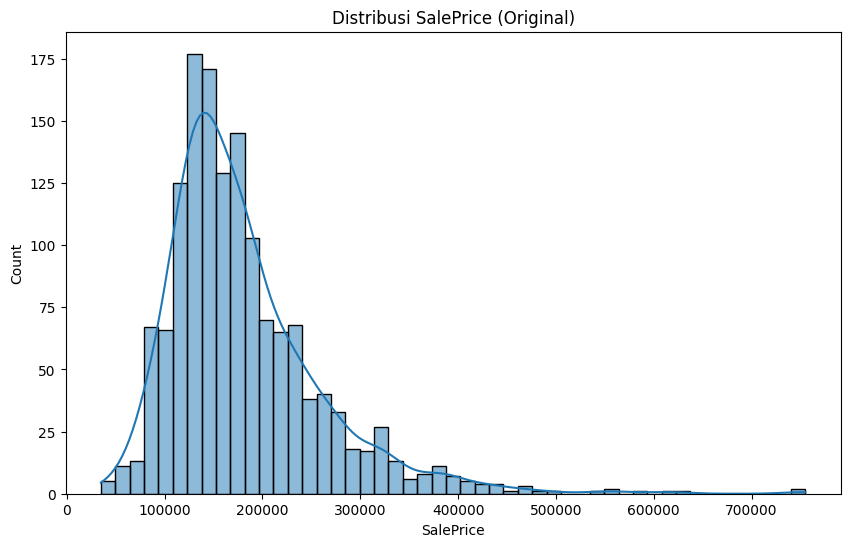

Skewness SalePrice: 1.882876
Kurtosis SalePrice: 6.536282


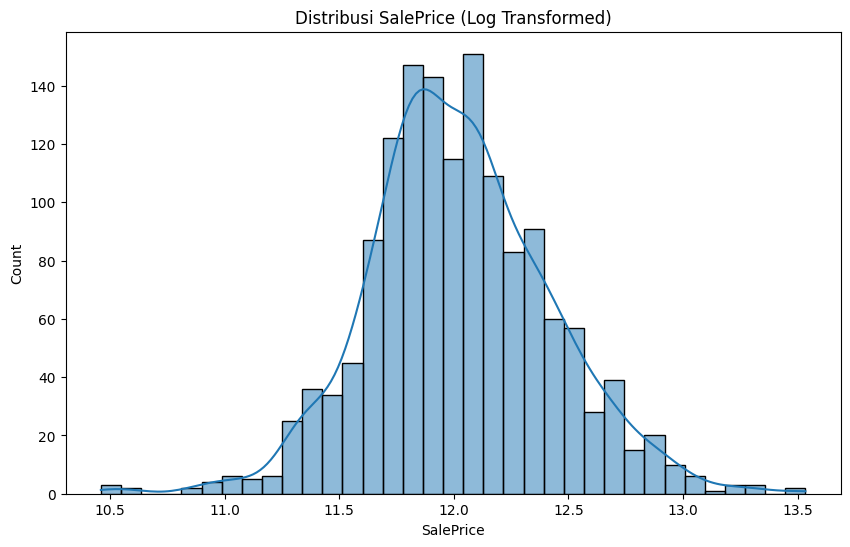

Ukuran data gabungan: (2919, 79)

Fitur dengan Missing Values Terbanyak:
              Missing Ratio
PoolQC            99.657417
MiscFeature       96.402878
Alley             93.216855
Fence             80.438506
MasVnrType        60.500171
FireplaceQu       48.646797
LotFrontage       16.649538
GarageQual         5.447071
GarageYrBlt        5.447071
GarageCond         5.447071
GarageFinish       5.447071
GarageType         5.378554
BsmtExposure       2.809181
BsmtCond           2.809181
BsmtQual           2.774923
BsmtFinType2       2.740665
BsmtFinType1       2.706406
MasVnrArea         0.787941
MSZoning           0.137033
BsmtFullBath       0.068517

Jumlah NaN setelah imputasi: 2

Skewness fitur numerik sebelum transformasi:
                    Skew
MiscVal        21.947195
PoolArea       16.898328
LotArea        12.822431
LowQualFinSF   12.088761
3SsnPorch      11.376065
KitchenAbvGr    4.302254
BsmtFinSF2      4.146143
EnclosedPorch   4.003891
ScreenPorch     3.946694
BsmtHalfBat

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb # Opsional, jika ingin mencoba XGBoost juga

import warnings
warnings.filterwarnings('ignore') # Mengabaikan peringatan untuk kebersihan output

# --- Langkah 1: Eksplorasi Data (EDA) & Pemahaman Masalah ---

# Memuat Data
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

# Simpan ID untuk submission nanti
train_ID = train_df['Id']
test_ID = test_df['Id']

# Hapus kolom ID karena tidak berguna untuk prediksi
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

print(f"Ukuran data Train: {train_df.shape}")
print(f"Ukuran data Test: {test_df.shape}")

# Analisis Target Variable ('SalePrice')
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribusi SalePrice (Original)')
plt.show()

print("Skewness SalePrice: %f" % train_df['SalePrice'].skew())
print("Kurtosis SalePrice: %f" % train_df['SalePrice'].kurt())

# --- Langkah 3 Awal: Transformasi Target ---
# Karena RMSLE adalah metriknya dan distribusinya miring, log transform adalah ide bagus.
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
y_train = train_df["SalePrice"] # Simpan target

plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribusi SalePrice (Log Transformed)')
plt.show()

# Gabungkan train dan test untuk preprocessing yang konsisten
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
all_data = pd.concat((train_df.drop(['SalePrice'], axis=1), test_df)).reset_index(drop=True)
print(f"Ukuran data gabungan: {all_data.shape}")

# --- Langkah 3 Lanjutan: Preprocessing & Cleaning ---

# Penanganan Missing Values
# Cek persentase missing values
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print("\nFitur dengan Missing Values Terbanyak:")
print(missing_data.head(20))

# Imputasi berdasarkan makna fitur (Contoh sederhana)
# Kategori: NaN sering berarti 'None' atau tidak ada fitur tsb
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

# Numerik: NaN bisa berarti 0 jika terkait fitur kategorikal 'None'
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars',
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

# Lainnya: Imputasi dengan modus (kategorikal) atau median (numerik)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
# LotFrontage mungkin berhubungan dengan Neighborhood, imputasi median per Neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Cek lagi apakah masih ada NaN
print(f"\nJumlah NaN setelah imputasi: {all_data.isnull().sum().sum()}")

# --- Langkah 4: Feature Engineering (Contoh Sederhana) ---

# Beberapa fitur numerik sebenarnya kategorikal
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Membuat fitur total luas
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Transformasi fitur numerik yang miring (skewed)
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print("\nSkewness fitur numerik sebelum transformasi:")
print(skewness.head(10))

skewness = skewness[abs(skewness['Skew']) > 0.75] # Ambil fitur yang sangat miring
print(f"Transformasi Box-Cox pada {skewness.shape[0]} fitur numerik")
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15 # Parameter lambda untuk Box-Cox
for feat in skewed_features:
    # all_data[feat] += 1e-6 # Tambahkan nilai kecil jika ada 0, jika diperlukan Box-Cox
    all_data[feat] = boxcox1p(all_data[feat], lam)

# --- Langkah 3 Akhir: Encoding Kategorikal ---
print(f"\nBentuk data sebelum One-Hot Encoding: {all_data.shape}")
all_data = pd.get_dummies(all_data)
print(f"Bentuk data setelah One-Hot Encoding: {all_data.shape}")

# Pisahkan kembali data train dan test
train_final = all_data[:ntrain]
test_final = all_data[ntrain:]
print(f"Ukuran data Train Final: {train_final.shape}")
print(f"Ukuran data Test Final: {test_final.shape}")


# --- Langkah 2 & 5: Strategi Validasi & Model Baseline (LightGBM) ---

# Mendefinisikan fungsi evaluasi RMSLE (karena target sudah di-log)
# Kita bisa pakai MSE langsung pada target log, lalu ambil akar kuadratnya.
def rmsle_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(train_final.values)
    # Gunakan neg_mean_squared_error karena cross_val_score memaksimalkan score
    rmse = np.sqrt(-cross_val_score(model, train_final.values, y_train,
                                     scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Model LightGBM (Parameter awal, belum di-tuning)
lgbm = lgb.LGBMRegressor(objective='regression',
                         num_leaves=5, # Lebih kecil untuk mencegah overfitting awal
                         learning_rate=0.05,
                         n_estimators=720, # Jumlah pohon
                         max_bin = 55, bagging_fraction = 0.8,
                         bagging_freq = 5, feature_fraction = 0.2319,
                         feature_fraction_seed=9, bagging_seed=9,
                         min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,
                         random_state=42) # Parameter ini hanya contoh, perlu tuning!

score = rmsle_cv(lgbm)
print(f"\nSkor CV (RMSLE) LightGBM: {score.mean():.4f} +/- {score.std():.4f}")

# --- Langkah 6: Hyperparameter Tuning (Dilewati dalam contoh ini) ---
# Di sini Anda akan menggunakan Optuna atau GridSearchCV/RandomizedSearchCV
# untuk mencari parameter terbaik berdasarkan skor CV.

# --- Langkah 7: Ensembling (Contoh: Averaging Sederhana) ---
# Kita bisa melatih beberapa model (misal: LGBM, XGBoost, Ridge)
# dan merata-ratakan prediksinya. Untuk simplifikasi, kita hanya gunakan LGBM.
# Dalam CV di atas, kita sudah dapat gambaran performa.

# --- Langkah 8: Prediksi Akhir & Submission ---

# Melatih model final pada seluruh data training
# (Gunakan parameter terbaik hasil tuning jika ada)
lgbm.fit(train_final.values, y_train)

# Membuat prediksi pada data test
lgbm_pred_log = lgbm.predict(test_final.values)

# Mengembalikan ke skala asli (ingat kita pakai log1p)
lgbm_pred = np.expm1(lgbm_pred_log)

# Membuat file submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = lgbm_pred
submission.to_csv('submission.csv', index=False)

print("\nFile submission.csv telah dibuat.")
print(submission.head())